# Implementing an application

Here we will show the steps you should follow to implement an application in deeplay.

## 1. Should I implement an application?

The first step is to ensure that what you want to implement is actually an application.
Most applications are composed of a single model, which is provided in the input arguments.

Instead, applications define the training and inference loops, and the loss function.
Applications should strive to be as model agnostic as possible, so that they can be used 
with any model that fits the input and output shapes. 

They should generally not define the model, but rather receive it as an argument. In 
some cases, it may be useful to have a default model, but this should be the exception.

Applications may also define custom metrics, or specialmethods used for inference. For
example, a classifier application may define a method to predict a hard label from the 
input, instead of the probabilities.

Examples of applications are:
- Classifier
- Regressor
- Segmentor
- VanillaGAN

## 2. Implementing the application

The first step is to create a new file in the `deeplay/applications` directory. It
should generally be in a subdirectory, named after the type of application. For example,
a binray classifier application should be in 
`deeplay/applications/classificaiton/binary.py`.

# 2.1 The base class

Applications should inherit from the `Application` class. This class is a subclass of
both `DeeplayModule` and `lightning.LightningModule`. This is to ensure that the 
application is trainable with PyTorch Lightning.

# 2.2 Example, the binary classifier

In [1]:
from deeplay.applications import Application
from deeplay.external import  Adam

import torch
import torch.nn as nn   
import torchmetrics as tm

class BinaryClassifier(Application):
    def __init__(
        self,
        model: nn.Module,
        **kwargs,
    ):
        # If no metrics are provided, add binary accuracy
        # Note: users can still set metrics=[] to disable all metrics
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]

        # Note, it's good practice to allow loss and optimizer to be passed in
        # as arguments, so that users can customize them if they want to.
        # We skip this for simplicity here.
        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3)
                         **kwargs)

        self.model = model

    def forward(self, x):
        return self.model(x)


## 2.2.1 compute_loss

The first method to implement is the `compute_loss` method. This method should receive
the predictions and the targets, and return the loss. In most cases, the default
behaviour is sufficient, but you may want to implement a custom evaluation.

In this case, we want to convert the targets to float, since the loss function expects
floats.

In [2]:
class BinaryClassifier(Application):
    def __init__(
        self,
        model: nn.Module,
        **kwargs,
    ):
        # If no metrics are provided, add binary accuracy
        # Note: users can still set metrics=[] to disable all metrics
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]

        # Note, it's good practice to allow loss and optimizer to be passed in
        # as arguments, so that users can customize them if they want to.
        # We skip this for simplicity here.
        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3)
                         **kwargs)

        self.model = model

    def forward(self, x):
        # We need to define the forward pass.
        return self.model(x)
    
    def compute_loss(self, y_hat, y):
        # We cast to float to match the expected type of the loss function
        return super().compute_loss(y_hat, y.float())

# 2.3 Annotations

It is important to add annotations to the class and methods to ensure that the
user knows what to expect. This is also useful for the IDE to provide 
autocomplete.

In [3]:
class BinaryClassifier(Application):

    # Only the attributes that are different from the parent class need to be defined
    model: nn.Module


    def __init__(
        self,
        model: nn.Module,
        **kwargs,
    ):
        if kwargs.get("metrics", False) is False:
            kwargs["metrics"] = [tm.Accuracy("binary")]
        super().__init__(loss=nn.BCELoss(), 
                         optimizer=Adam(lr=1e-3),
                         **kwargs)

        self.model = model

    def forward(self, x):
        return self.model(x)
    
    def compute_loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return super().compute_loss(y_hat, y.float())

## 2.3 Documenting the application

The next step is to document the application. This should include a description of 
the application, the input and output shapes, and the arguments that can be passed to
the application.

```python
class BinaryClassifier(Application):
    """Binary Classifier Application

    This class is a binary classifier application that can be used to train a model
    to classify data into two classes.

    If no metrics are provided, the binary accuracy is used.
    Set `metrics=[]` to disable all metrics.


    Parameters
    ----------
    model : nn.Module
        The model to use as the backbone
    kwargs : dict
        Additional arguments to pass to the Application class
        See `deeplay.applications.Application` for more details

    Input
    -----
    x : torch.Tensor
        The input tensor of shape (N, ...)
        Where N is the batch size and ... is the input shape.
    
    Output
    ------
    y : torch.Tensor
        The output tensor of shape (N, 1)
        Where N is the batch size and 1 is a single value between 0 and 1.


    Target
    ------
    target : torch.Tensor (float, long, bool)
        The target tensor of shape (N, num_classes).
        Where N is the batch size and num_classes is the number of classes.
        The values of the target should be between 0 and 1 (inclusive)
        Values like 0.1 and 0.9 are allowed.

    Evaluation
    ----------
    ```python
    x = model(x)
    ```

    Examples
    --------
    >>> net = MultiLayerPerceptron(3, [64], 1)
    >>> application = BinaryClassifier(net).build()
    >>> x = torch.rand(1000, 3)
    >>> target = x.sum(dim=1, keepdim=True) > 1.5
    >>> hist = application.fit((x, target), epochs=10)

    """
    # [rest of the code]
````

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss              │      0 │
│ 1 │ train_metrics │ MetricCollection     │      0 │
│ 2 │ val_metrics   │ MetricCollection     │      0 │
│ 3 │ test_metrics  │ MetricCollection     │      0 │
│ 4 │ model         │ MultiLayerPerceptron │    321 │
│ 5 │ optimizer     │ Adam                 │      0 │
└───┴───────────────┴──────────────────────┴────────┘

Trainable params: 321                                                                                              
Non-trainable params: 0                                                                                            
Total params: 321                                                                                                  
Total estimated model params size (MB): 0

Output()

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Step'>,
        <Axes: title={'center': 'Binaryaccuracy'}, xlabel='Step'>],
       dtype=object))

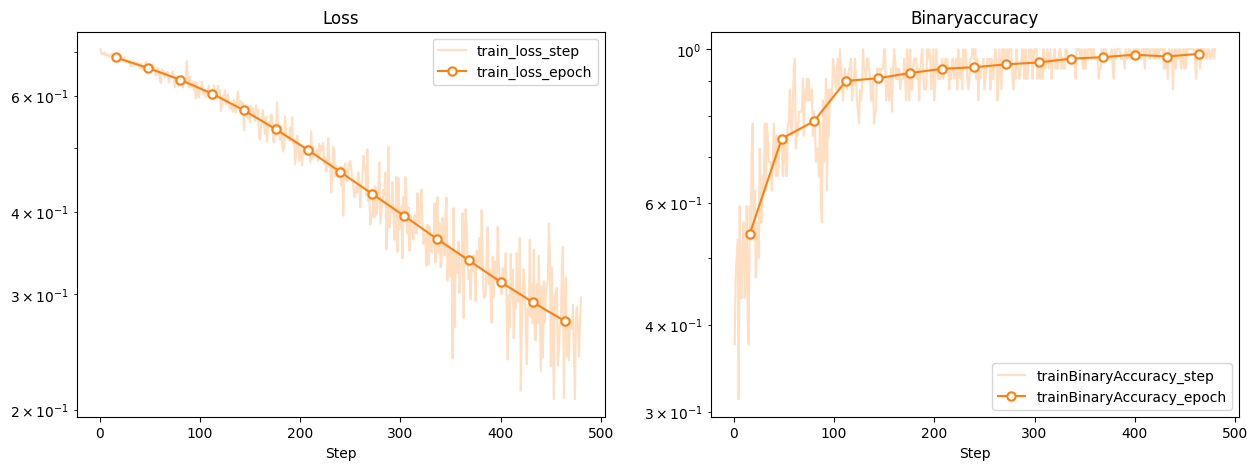

In [4]:
from deeplay.components import MultiLayerPerceptron

net = MultiLayerPerceptron(3, [64], 1, out_activation=nn.Sigmoid)
application = BinaryClassifier(net).build()

x = torch.rand(1000, 3)
target = x.sum(dim=1, keepdim=True) > 1.5

hist = application.fit((x, target), max_epochs=15)
hist.plot()